In [ ]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json, matplotlib, sys, time
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
import seaborn as sns; from sqlalchemy import create_engine
from IPython import display
%matplotlib inline

# When are users most active on the tile... and how experienced are they?

In [ ]:
study_tiles = json.loads(open('../study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

In [ ]:
years = [2005+i for i in range(12)]
years

In [ ]:
# Create connections for panda queries
pd_engines = []
pd_connections = []
for idx, year in enumerate(years):
    pd_engines.append( create_engine("postgresql://anderstj@127.0.0.1:5432/world-{0}".format(year)) )
    pd_connections.append(pd_engines[idx].connect())

def reset(pd_connections):
    new_cons = []
    for idx, con in enumerate(pd_connections):
        con.close()
        new_cons.append(pd_engines[idx].connect())
    return new_cons

# pd_connections = reset(pd_connections)

In [ ]:
def get_all_users_who_edited_tile(tile):
    users_on_tile = []
    for idx, year in enumerate(years):
        print(year, end=" . ")
        query_string = """SELECT distinct(uid) FROM per_tile WHERE quadkey = '{0}'""".format(tile['quad'])
        year_df = pd.read_sql_query(query_string,con=pd_connections[idx])
        users_on_tile = np.append(users_on_tile,year_df.uid.values)
    return np.unique(users_on_tile)

def annual_worker_function(args):
    """
    Input: List of users and a year of choice
    Returns: Dictionary, keyed by UID of all a user's edits for given year
    """
    (user_list, year_idx, q) = args
    dict_to_return = {}

    #Query for 50 users at a time
    for sub_list in [user_list[i:i + 50] for i in range(0, len(user_list), 50)]:
    
        query_string = """SELECT per_tile.quadkey,
                                 per_tile.year,
                                 per_tile.uid,
                                 per_tile.buildings,
                                 per_tile.road_km,
                                 per_tile.amenities,
                                 per_tile.edits,
                                 array_length(per_tile.active_days,1) AS "num_days",
                                 user_stats.uid AS "user_stats_uid",
                                 user_stats.name AS "user_name",
                                 user_stats.year AS "total_year",
                                 user_stats.buildings AS "total_buildings",
                                 user_stats.road_km AS "total_road_km",
                                 user_stats.amenities AS "total_amenities",
                                 user_stats.edits AS "total_edits",
                                 array_length(user_stats.active_days,1) AS "total_active_days"
                          FROM per_tile, user_stats 
                          WHERE per_tile.uid = user_stats.uid AND 
                                per_tile.uid = ANY(ARRAY[%s])"""%(", ".join([str(i) for i in sub_list]))
        df = pd.read_sql_query(query_string, con=pd_connections[year_idx])
        
#         with open('tmp.log','w') as oFile:
#             oFile.write(df.to_csv())

        for uid in df['uid'].unique():
            dict_to_return[uid] = df[:][df.uid == uid]
            q.put(1)
    return dict_to_return

def build_user_distributions(uids):
    """
        Given a list of user ids, spin up 12 processes (1 per year) to get back dictionaries, keyed by UID
            of all a user's tiles for that year; then combine all of the years.
        
        Returns: A dictionary: { UID : DataFrame of all a user's edits (across all years) }
    """
    m = Manager()
    q = m.Queue()
    p = Pool(12)
    args = [ (uids, year_idx, q) for year_idx in range(12)]
    
    max_val = round(len(uids)*len(args)*0.4)

    result = p.map_async(annual_worker_function, args)
    
    while True:
        if result.ready():
            break
        else:
            size = q.qsize()
            sys.stderr.write("\r "+str(size)+ "/ ~ " + str(max_val))
            time.sleep(1)
    
    aggregated = {}
    
    for year_data in result.get():
        for uid, data in year_data.items():
            if uid in aggregated:
                aggregated[uid]['df'] = pd.concat([aggregated[uid]['df'], data], ignore_index=True)
            else:
                #This is the first we see this user
                aggregated[uid] = {'df':data}
    p.close()
    return aggregated

### With each user's dataframe, compute user focus stats

In [ ]:
def calculate_user_focus(args):
    """
    
    """
    df, q = args
    agged_quad = df.groupby('quadkey').aggregate({'buildings':sum,
                                                 'road_km'  :sum,
                                                 'edits'    :sum,
                                                 'amenities':sum,
                                                 'num_days' :sum})
    
    agged_quad['percent_user_road_km']   = agged_quad.road_km   / agged_quad.road_km.sum()*100
    agged_quad['percent_user_buildings'] = agged_quad.buildings / agged_quad.buildings.sum()*100
    agged_quad['percent_user_amenities'] = agged_quad.amenities / agged_quad.amenities.sum()*100
    agged_quad['percent_user_edits']     = agged_quad.edits     / agged_quad.edits.sum()*100
    

    annual_stats = pd.DataFrame()
    for year in df.total_year.unique():
        this_year = df[['uid','user_name','year','total_buildings','total_road_km','total_amenities','total_edits','total_active_days']].query('year=={0}'.format(year)).head(1)
        annual_stats = pd.concat( [annual_stats, this_year], ignore_index=True)
    
    if(q):
        q.put(1)
    return (agged_quad, annual_stats)

def process_dictionary_of_users(user_dict):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], q) for uid in sorted_users]
    result = p.map_async(calculate_user_focus, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['tiles'] = res[idx][0]
        user_dict[user]['annual'] = res[idx][1]
        
    p.close()

In [ ]:
def pull_out_study_tile(args):
    """
        For each user, pull out just the quadkey we want; but also tally the annual stuff...
    """
    df, quad, q = args
    
    tile_of_interest = pd.DataFrame(df.query("quadkey=='{0}'".format(quad)))

    if(q):
        q.put(1)
    return tile_of_interest

def process_dictionary_of_users_for_study_tile_stats(user_dict, quad):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], quad, q) for uid in sorted_users]
    result = p.map_async(pull_out_study_tile, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['toi'] = res[idx]
        
    p.close()

In [ ]:
def build_all_stats_for_tile(current_tile):
    """
    
    """
    current_tile_df = pd.DataFrame()
    for u,data in current_tile['users'].items():
        data['tiles']['uid'] = u
        data['tiles']['total_editing_days_ever'] = data['annual'].total_active_days.sum()
        data['tiles']['total_buildings_ever'] = data['annual'].total_buildings.sum()
        data['tiles']['total_road_km_ever'] = data['annual'].total_road_km.sum()
        data['tiles']['total_amenities_ever'] = data['annual'].total_amenities.sum()
        data['tiles']['total_edits_ever'] = data['annual'].total_edits.sum()
        current_tile_df = pd.concat([current_tile_df, pd.DataFrame(data['tiles'].query("quadkey=='{0}'".format(current_tile['quad'])))],ignore_index=True)

    current_tile_df['percent_tile_road_km']   = current_tile_df.road_km   / current_tile_df.road_km.sum()*100
    current_tile_df['percent_tile_buildings'] = current_tile_df.buildings / current_tile_df.buildings.sum()*100
    current_tile_df['percent_tile_amenities'] = current_tile_df.amenities / current_tile_df.amenities.sum()*100
    current_tile_df['percent_tile_edits']     = current_tile_df.edits     / current_tile_df.edits.sum()*100
    
    return current_tile_df

# Study Tiles: Load data for a specific study tile

In [ ]:
for idx, tile in enumerate(study_tiles):
    print(idx, tile['name'])

## 1. Get the `user_list`

In [ ]:
"""
    First: Set the index for the study tile you want.
"""
study_tile_idx = 2

In [ ]:
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx])

In [ ]:
print("Found: {0} users".format(len(study_tiles[study_tile_idx]['user_list'])))

## 2. Build the User Distributions
If this doesn't run, run the cell 2 above again)

In [ ]:
study_tiles[study_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['user_list'])

### Check these results

In [18]:
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,120221323223,2006,137,0,0.0,0,3,1,137,simone,2006,0,0.0000,0,24,1
1,120221323222,2006,137,0,0.0,0,21,1,137,simone,2006,0,0.0000,0,24,1
2,031313131112,2007,137,0,0.0,2,2,1,137,simone,2007,0,92.2827,2,153,8
3,120221323021,2007,137,0,0.0,0,1,1,137,simone,2007,0,92.2827,2,153,8
4,120221323022,2007,137,0,0.0,0,1,1,137,simone,2007,0,92.2827,2,153,8


## 3. Get tile focus for each user

In [19]:
process_dictionary_of_users(study_tiles[study_tile_idx]['users'])

 325/325

## 3.5 Pull out per-user-study tile stats

In [20]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['users'], study_tiles[study_tile_idx]['quad'])

 321/325

### Inspect these

In [21]:
# So what's saved from this?
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['annual'].head())
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['toi'].head())

,buildings,road_km,amenities,edits,num_days,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
021112001110,0,0.0,0,1,1,0.0,0.0,0.0,0.000174
021112001111,0,0.0,0,1,1,0.0,0.0,0.0,0.000174
021112001112,0,0.0,0,1,1,0.0,0.0,0.0,0.000174
021112001130,0,0.0,0,1,1,0.0,0.0,0.0,0.000174
021112001131,0,0.0,0,1,1,0.0,0.0,0.0,0.000174


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,137,simone,2006,0,0.0000,0,24,1
1,137,simone,2007,0,92.2827,2,153,8
2,137,simone,2008,13,486.1230,122,38917,85
3,137,simone,2009,505465,239.5140,2391,516880,63
4,137,simone,2010,342,163.0080,184,2170,67


,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
6919,132312223332,2013,137,1,0.0,0,6,1,137,simone,2013,692,180.318,289,1963,64


Processed Study tiles now have the following attributes: 

- **name**: Name of Region
- **user_list**: List of UIDs of users who have edited on this tile
- **users**: Dictionary, keyed by UID
  - `uid`:
    - **df**: Full dataframe of all edits on all tiles by this user
    - **tiles**: DataFrame of unique tiles, summed over all years
    - **annual**: DataFrame of Editing Aggregates over all tiles, per year
    - **toi**: DataFrame of just edits to the study tile per user

# Begin Analysis

In [24]:
print("Current Study Tile: {0}".format(study_tiles[study_tile_idx]['name']))
print("\tUsers: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))

Current Study Tile: Tacloban
	Users: 325


In [25]:
overtime_df = pd.DataFrame()
for uid, data in study_tiles[study_tile_idx]['users'].items():

    safe_df = pd.DataFrame(data['annual'].sort_values(by='year'))
    safe_df['active_days_to_date'] = safe_df.total_active_days.cumsum()

    new_df = data['toi'].merge(safe_df[['active_days_to_date','year']], on='year')

    overtime_df = pd.concat([overtime_df, new_df],ignore_index=True)

overtime_df.head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,132312223332,2013,1772032,2,0.000000,1,12,1,1772032,Vincent Génin,2013,22,6.65890,187,396,11,11
1,132312223332,2013,188930,0,0.000000,0,1,1,188930,JLZIMMERMANN,2013,1505,1184.31000,2484,22010,335,881
2,132312223332,2013,1784020,55,0.000000,0,55,2,1784020,JPavlik,2013,276,2.86617,0,292,8,8
3,132312223332,2013,167945,0,0.212441,0,2,1,167945,Xinfe,2013,759,247.51700,174,2798,32,190
4,132312223332,2013,178186,334,6.782210,0,379,2,178186,mdk,2013,18695,3266.83000,1266,127477,161,921


In [26]:
overtime_df.query('active_days_to_date>10').query('year==2010').head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
179,132312223332,2010,45827,0,0.415658,0,1,1,45827,danyx,2010,9,184.847,60,735,36,113
189,132312223332,2010,24338,0,0.000000,0,1,1,24338,Rally,2010,152,4364.480,786,6973,104,141
259,132312223332,2010,11126,0,0.000000,0,1,1,11126,seav,2010,1052,1540.610,1190,12601,176,345
305,132312223332,2010,31138,0,0.000000,0,2,1,31138,5EE,2010,352,4674.800,51,15709,113,452
343,132312223332,2010,69076,0,47.552800,8,98,8,69076,axk,2010,92,2737.580,338,4527,115,170


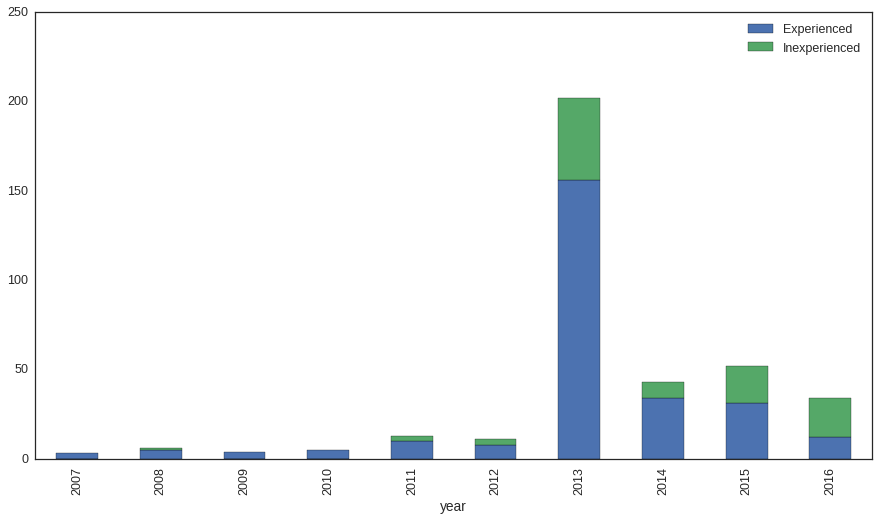

In [27]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

threshold = 7

gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

gt_10.columns = ['Experienced']
lt_10.columns = ['Inexperienced']

gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

<hr>
# Run Tile-by-Tile Comparisons
For each study tile, we have _comparable_ tiles, these are the tiles of most interest, because the difference in patterns between these tiles and our study tiles is what makes the analysis.

## 1. Get a _comparable_ tile

In [28]:
if 'compare_tiles' in study_tiles[study_tile_idx]:
    print("Comparable Tiles for {0}: ".format(study_tiles[study_tile_idx]['name']))
    for idx, compare in enumerate(study_tiles[study_tile_idx]['compare_tiles']):
        print("\t{0}, '{1}'".format(idx, compare['quad']))

Comparable Tiles for Tacloban: 
	0, '132303033311'
	1, '132303033313'


In [29]:
#Which tile to compare? (from within the comparable study tiles)
compare_tile_idx=0

## 2. Get Users

In [31]:
pd_connections = reset(pd_connections)
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

## 3. Build actual user distribution (may take a few minutes)
If it fails, run the above cell again (probably twice)

In [32]:
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'])

 319/ ~ 350

In [33]:
# Check these results?
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,132303120223,2006,1417,0,0.0,0,15,4,1417,maning,2006,0,0.0,0,212,6
1,132303122000,2006,1417,0,0.0,0,19,3,1417,maning,2006,0,0.0,0,212,6
2,132303120230,2006,1417,0,0.0,0,177,3,1417,maning,2006,0,0.0,0,212,6
3,132303122001,2006,1417,0,0.0,0,1,1,1417,maning,2006,0,0.0,0,212,6
4,132301103230,2007,1417,0,0.0,0,1,1,1417,maning,2007,134,3123.1,193,15978,150


## 3.5 Pull out per-user-study tile stats

In [34]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'], study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['quad'])

 72/73

## 4. Now process user focus for compare tiles

In [36]:
process_dictionary_of_users(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['annual'].head())

 73/73

,buildings,road_km,amenities,edits,num_days,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
021230312302,0,2.859930,0,2,1,0.003572,0.0,0.0,0.000650
023310311001,0,4.237360,0,2,1,0.005293,0.0,0.0,0.000650
023313121033,0,55.814500,0,129,1,0.069721,0.0,0.0,0.041908
023313121211,0,0.546778,0,1,1,0.000683,0.0,0.0,0.000325
032003033002,0,2.505910,0,1,1,0.003130,0.0,0.0,0.000325


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,1417,maning,2006,0,0.00,0,212,6
1,1417,maning,2007,134,3123.10,193,15978,150
2,1417,maning,2008,951,11360.70,2994,47366,195
3,1417,maning,2009,758,8933.49,1075,58975,216
4,1417,maning,2010,216,5580.00,568,17904,189


## 5. Build Compare Tile Full Stats

In [37]:
compare_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])
compare_tile_df.count().head()

buildings    73
road_km      73
amenities    73
edits        73
num_days     73
dtype: int64

# Now compare the tiles

First, basic stats: 

In [38]:
print("Users on Study Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['user_list']), len(current_tile_df)))
print("Users on Compare Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list']), len(compare_tile_df)))

Users on Study Tile: 325, 325
Users on Compare Tile: 73, 73


In [39]:
compare_overtime_df = pd.DataFrame()
for uid, data in study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'].items():

    safe_df = pd.DataFrame(data['annual'].sort_values(by='year'))
    safe_df['active_days_to_date'] = safe_df.total_active_days.cumsum()

    new_df = data['toi'].merge(safe_df[['active_days_to_date','year']], on='year')

    compare_overtime_df = pd.concat([compare_overtime_df, new_df],ignore_index=True)

compare_overtime_df.head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,132303033311,2016,1942402,8,0.000000,0,8,1,1942402,wherehavejobyn,2016,9120,0.367473,2,9125,22,27
1,132303033311,2016,3724858,1190,0.298397,0,1193,1,3724858,audz,2016,5314,7.233310,2,13444,14,14
2,132303033311,2015,118021,0,0.000000,1,1,1,118021,maggot27,2015,22208,3614.850000,5177,58783,34,166
3,132303033311,2014,2331271,0,0.000000,0,1,1,2331271,Nate Joshua,2014,1320,930.919000,332,10303,59,59
4,132303033311,2014,2444680,0,0.000000,0,2,2,2444680,ivet,2014,189,0.000000,369,7721,22,22


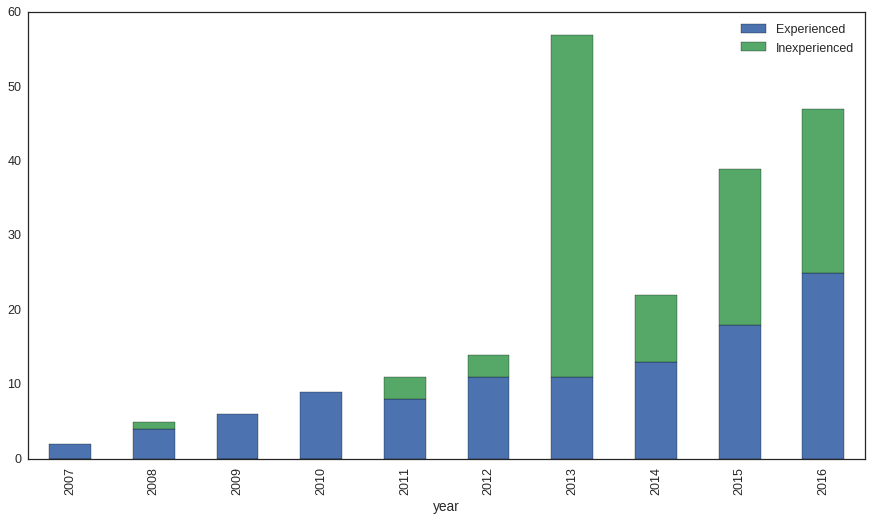

In [40]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

threshold = 7

compare_gt_10 = compare_overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_lt_10 = compare_overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

compare_gt_10.columns = ['Experienced']
compare_lt_10.columns = ['Inexperienced']

compare_gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

## Analysis 

The comparable Tacloban tiles are also in the Philippines. Note, however, that this particular tile had more _inexperienced users_ than Tacloban.